### Insight users 
The objective is to provide a macro-level characterization of the company's Teams.i.e working hours and workload

In [38]:
#install libraries 
import pandas as pd 
pd.set_option('display.max_columns', None)
import json

In [ ]:
#read the datasets 

def handle_bad_lines(bad_line):
    print(f"Ligne problématique : {bad_line}")
    return pd.Series()
jira_issues = pd.read_excel('jira_issue.xlsx')

jira_issues
jira_issues.shape 
jira_issues.info()
jira_issues

In [ ]:
jira_users = pd.read_excel('jira_users.xlsx')
jira_users.info()
jira_users

In [41]:
jira_users.isnull().sum()

active           0
accountId        0
accountType      0
displayName      0
emailAddress    72
dtype: int64

In [ ]:
jira_issue_types = pd.read_excel('jira_issue_types.xlsx')
jira_issue_types.shape 
jira_issue_types.info()
jira_issue_types


In [43]:
jira_issue_types.isnull().sum()

id                0
name              0
subtask           0
avatarId          1
description       4
hierarchyLevel    0
dtype: int64

In [ ]:
jira_projects = pd.read_excel('jira_projects.xlsx')
jira_projects.shape 
jira_projects.info()
jira_projects

In [45]:
jira_projects.isnull().sum()

id                0
key               0
lead              0
name              0
projectTypeKey    0
dtype: int64

In [ ]:
jira_sprints = pd.read_excel('jira_sprints.xlsx')
jira_sprints.shape 
jira_sprints.info()
jira_sprints

In [47]:
jira_sprints.isnull().sum()

id              0
name            0
state           0
endDate         1
startDate       1
completeDate    2
dtype: int64

In [ ]:
jira_sprint_issues = pd.read_excel('jira_sprint_issues.xlsx')
jira_sprint_issues.shape 
jira_sprint_issues.info()
jira_sprint_issues

In [49]:
jira_sprint_issues.isnull().sum()

id          0
key         0
fields      0
issueId     0
updated     0
sprintId    0
dtype: int64

In [ ]:
jira_issue_fields = pd.read_excel('jira_issue_field.xlsx')
jira_issue_fields.shape 
jira_issue_fields.info()
jira_issue_fields

In [51]:
jira_issue_fields.isnull().sum()

id        0
key       0
name      0
custom    0
schema    4
dtype: int64

In [ ]:
jira_issue_custom_field_contexts = pd.read_excel('jira_issue_custom_field_contexts.xlsx')
jira_issue_custom_field_contexts.shape 
jira_issue_custom_field_contexts.info()
jira_issue_custom_field_contexts

In [53]:
jira_issue_custom_field_contexts.isnull().sum()

id                 0
name               0
fieldId            0
fieldType          0
isGlobalContext    0
dtype: int64

In [ ]:
jira_issue_custom_field_options = pd.read_excel('jira_issue_custom_field_options.xlsx')
jira_issue_custom_field_options.shape 
jira_issue_custom_field_options.info()
jira_issue_custom_field_options

In [55]:
jira_issue_custom_field_options.isnull().sum()

id           0
value        0
fieldId      0
contextId    0
dtype: int64

In [ ]:
tempo_worklogs = pd.read_csv('tempo_worklogs.csv')
tempo_worklogs.shape 
tempo_worklogs.info()
tempo_worklogs

In [81]:
tempo_worklogs.isna().sum()

self                     0
issue                    0
author                   0
createdAt                0
startDate                0
startTime                0
updatedAt                0
attributes               0
description              0
tempoWorklogId           0
billableSeconds          0
timeSpentSeconds         0
_airbyte_raw_id          0
_airbyte_extracted_at    0
_airbyte_meta            0
dtype: int64

In [ ]:
#extraction "accountID" de la colonne field de la table Issues :
df = jira_issues

def extract_multiple_values(json_str, key):
    try:
        data = json.loads(json_str)
        values = []
        def search_key(obj):
            if isinstance(obj, dict):
                for k, v in obj.items():
                    if k == key:
                        values.append(v)
                    elif isinstance(v, (dict, list)):
                        search_key(v)
            elif isinstance(obj, list):
                for item in obj:
                    search_key(item)
        search_key(data)
        return values
    except json.JSONDecodeError:
        return None
df['accountIds'] = df['fields'].apply(lambda x: extract_multiple_values(x, 'accountId'))
print(df[['fields', 'accountIds']].head())
df_display = df[['fields', 'accountIds']]

In [60]:
# Compter le nombre de personnes actives
active_count = jira_users['active'].sum()

# Compter le nombre de personnes inactives
inactive_count = (~jira_users['active']).sum()

# Afficher les résultats
print(f"Nombre de personnes actives : {active_count}")
print(f"Nombre de personnes inactives : {inactive_count}")

Nombre de personnes actives : 1432
Nombre de personnes inactives : 29


In [ ]:
# Étape 1 : Extraire l'accountId de la colonne 'author'
def extract_account_id(author_json):
    author_dict = json.loads(author_json.replace("'", "\""))
    return author_dict['accountId']

tempo_worklogs['accountId'] = tempo_worklogs['author'].apply(extract_account_id)

# Étape 2 : Fusionner les DataFrames tempo_worklogs et jira_users
merged_df = pd.merge(tempo_worklogs, jira_users[['accountId', 'displayName']], on='accountId', how='left')

# Étape 3 : Calculer le taux de remplissage pour chaque colonne de temps par utilisateur
time_columns = ['billableSeconds', 'timeSpentSeconds']

result = merged_df.groupby('displayName')[time_columns].agg(['count', 'sum'])
result.columns = ['_'.join(col).strip() for col in result.columns.values]

# Trier les résultats par le taux de remplissage de tempoWorklogId décroissant
result = result.sort_values('timeSpentSeconds_sum', ascending=False)

# Afficher les résultats
display(result)



In [ ]:
#extraire les accound id des jsons 

def extract_account_id(fields):
    try:
        fields_dict = json.loads(fields.replace("'", "\""))
        return fields_dict.get('creator', {}).get('accountId')
    except:
        return None

# Appliquer la fonction pour extraire les accountId
jira_issues['accountId'] = jira_issues['fields'].apply(extract_account_id)

# Compter le nombre d'issues par utilisateur
issue_count_per_user = jira_issues['accountId'].value_counts().reset_index()
issue_count_per_user.columns = ['accountId', 'issue_count']

# Fusionner avec jira_users pour obtenir les noms d'affichage
result = pd.merge(issue_count_per_user, jira_users[['accountId', 'displayName']], on='accountId', how='left')

# Trier par nombre d'issues décroissant
result = result.sort_values('issue_count', ascending=False)

# Afficher les résultats
display(result)


In [ ]:
#sortir les collaborateurs qui ont travaillé sur chaque projet 

def extract_project_and_creator(row):
    try:
        fields = json.loads(row['fields'].replace("'", "\""))
        project_id = fields['project']['id']
        creator_id = fields['creator']['accountId']
        creator_name = fields['creator']['displayName']
        return pd.Series([project_id, creator_id, creator_name])
    except:
        return pd.Series([None, None, None])

# Appliquer la fonction pour extraire les informations
jira_issues[['projectId', 'creatorId', 'creatorName']] = jira_issues.apply(extract_project_and_creator, axis=1)

# Grouper par projectId et obtenir la liste des utilisateurs uniques ainsi que leur nombre
project_users = jira_issues.groupby('projectId').agg({
    'creatorName': lambda x: list(set(x)),
    'projectKey': 'first',  # Supposons que projectKey est unique pour chaque projectId
    'creatorId': 'nunique'  # Compter le nombre d'utilisateurs uniques
}).reset_index()

# Renommer les colonnes pour plus de clarté
project_users.columns = ['projectId', 'users', 'projectKey', 'user_count']

# Trier par projectId
project_users = project_users.sort_values('projectId')

# Afficher les résultats
for _, row in project_users.iterrows():
    print(f"Projet ID: {row['projectId']}, Clé: {row['projectKey']}")
    print(f"Nombre d'utilisateurs: {row['user_count']}")
    print("Utilisateurs:")
    for user in row['users']:
        print(f"  - {user}")
    print()

# Afficher le nombre total de projets
print(f"Nombre total de projets : {len(project_users)}")

# Afficher le nombre total d'utilisateurs uniques à travers tous les projets
total_unique_users = jira_issues['creatorId'].nunique()
print(f"Nombre total d'utilisateurs uniques : {total_unique_users}")

In [ ]:
#calculer le temps passé par projet 


def extract_project_and_time(row):
    try:
        fields = json.loads(row['fields'].replace("'", "\""))
        project_id = fields['project']['id']
        project_key = fields['project']['key']
        project_name = fields['project']['name']
        time_spent = sum(worklog['timeSpentSeconds'] for worklog in fields['worklog']['worklogs'])
        return pd.Series([project_id, project_key, project_name, time_spent])
    except:
        return pd.Series([None, None, None, 0])

# Appliquer la fonction à chaque ligne du DataFrame jira_issues
jira_issues[['projectId', 'projectKey', 'projectName', 'timeSpent']] = jira_issues.apply(extract_project_and_time, axis=1)

# Grouper par projet et sommer le temps passé
project_time = jira_issues.groupby(['projectId', 'projectKey', 'projectName'])['timeSpent'].sum().reset_index()

# Trier par temps passé décroissant
project_time = project_time.sort_values('timeSpent', ascending=False)

# Convertir les secondes en heures et en jours de travail
project_time['timeSpentHours'] = project_time['timeSpent'] / 3600
project_time['timeSpentWorkDays'] = project_time['timeSpentHours'] / 8

# Afficher les résultats
print("Temps passé par projet :")
for _, row in project_time.iterrows():
    print(f"Projet : {row['projectName']} (ID: {row['projectId']}, Clé: {row['projectKey']})")
    print(f"  Temps passé : {row['timeSpentWorkDays']:.2f} jours de travail ({row['timeSpentHours']:.2f} heures)")
    print()

# Calculer le temps total passé sur tous les projets
total_time = project_time['timeSpent'].sum()
total_time_hours = total_time / 3600
total_time_work_days = total_time_hours / 8

print(f"Temps total passé sur tous les projets : {total_time_work_days:.2f} jours de travail ({total_time_hours:.2f} heures)")

In [ ]:
def extract_priority_and_creator(row):
    try:
        fields = json.loads(row['fields'].replace("'", "\""))
        priority = fields.get('priority', {}).get('name', 'Non définie')
        creator_id = fields.get('creator', {}).get('accountId', 'Inconnu')
        creator_name = fields.get('creator', {}).get('displayName', 'Inconnu')
        return pd.Series([priority, creator_id, creator_name])
    except:
        return pd.Series(['Erreur', 'Erreur', 'Erreur'])

# Appliquer la fonction pour extraire la priorité et le créateur
jira_issues[['priority', 'creator_id', 'creator_name']] = jira_issues.apply(extract_priority_and_creator, axis=1)

# Grouper par créateur et priorité, et compter le nombre de tâches
task_count = jira_issues.groupby(['creator_name', 'priority']).size().unstack(fill_value=0)

# Ajouter une colonne pour le total des tâches par utilisateur
task_count['Total'] = task_count.sum(axis=1)

# Trier par le nombre total de tâches décroissant
task_count = task_count.sort_values('Total', ascending=False)

# Afficher les résultats
display(task_count)

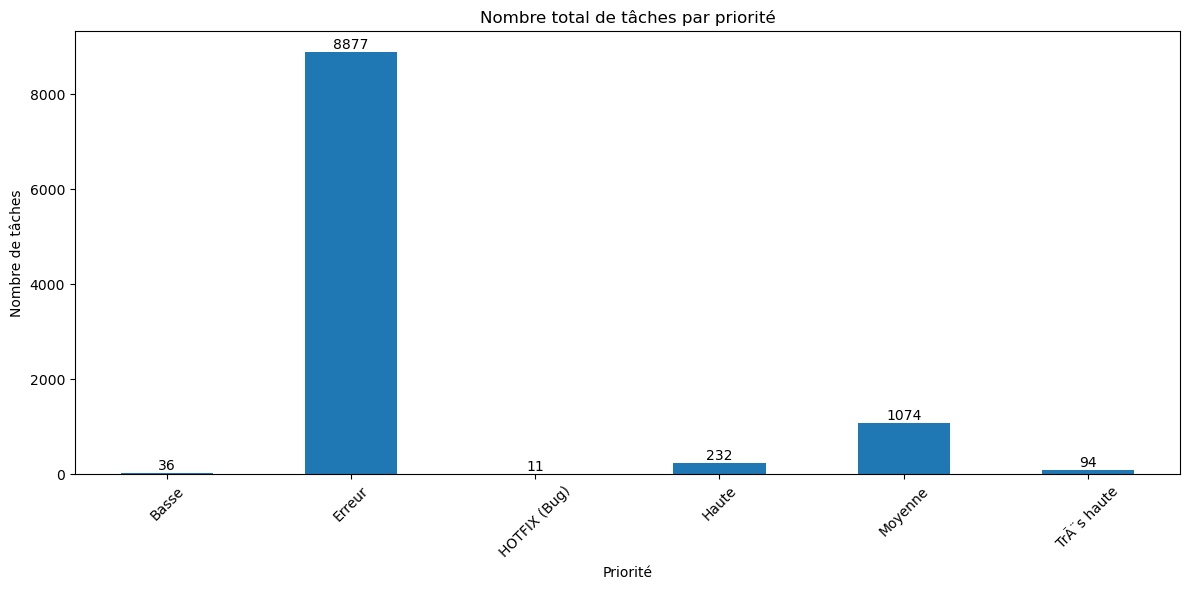

priority
Basse             36
Erreur          8877
HOTFIX (Bug)      11
Haute            232
Moyenne         1074
TrÃ¨s haute       94
Name: count, dtype: int64


In [67]:
import matplotlib.pyplot as plt

def extract_priority_and_creator(row):
    try:
        fields = json.loads(row['fields'].replace("'", "\""))
        priority = fields.get('priority', {}).get('name', 'Non définie')
        creator_id = fields.get('creator', {}).get('accountId', 'Inconnu')
        creator_name = fields.get('creator', {}).get('displayName', 'Inconnu')
        return pd.Series([priority, creator_id, creator_name])
    except:
        return pd.Series(['Erreur', 'Erreur', 'Erreur'])

# Appliquer la fonction pour extraire la priorité et le créateur
jira_issues[['priority', 'creator_id', 'creator_name']] = jira_issues.apply(extract_priority_and_creator, axis=1)

# Grouper par priorité et compter le nombre de tâches
priority_count = jira_issues['priority'].value_counts().sort_index()

# Créer l'histogramme
plt.figure(figsize=(12, 6))
priority_count.plot(kind='bar')
plt.title('Nombre total de tâches par priorité')
plt.xlabel('Priorité')
plt.ylabel('Nombre de tâches')
plt.xticks(rotation=45)

# Ajouter les valeurs sur chaque barre
for i, v in enumerate(priority_count):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Afficher les résultats numériques
print(priority_count)

In [ ]:
def extract_user_info(author_json):
    author_dict = json.loads(author_json.replace("'", "\""))
    return author_dict.get('accountId', 'Inconnu')

def extract_category(attributes_json):
    attributes_dict = json.loads(attributes_json.replace("'", "\""))
    values = attributes_dict.get('values', [])
    for value in values:
        if value.get('key') == '_Type_':
            return value.get('value')
    return 'Non défini'

# Extraire l'accountId et la catégorie
tempo_worklogs['accountId'] = tempo_worklogs['author'].apply(extract_user_info)
tempo_worklogs['category'] = tempo_worklogs['attributes'].apply(extract_category)

# Convertir timeSpentSeconds en type numérique
tempo_worklogs['timeSpentSeconds'] = pd.to_numeric(tempo_worklogs['timeSpentSeconds'], errors='coerce')

# Jointure avec la table jira_users
merged_df = pd.merge(tempo_worklogs, jira_users[['accountId', 'displayName']], on='accountId', how='left')

# Grouper par utilisateur (displayName) et catégorie, puis sommer le temps passé
time_by_user_and_category = merged_df.groupby(['displayName', 'category'])['timeSpentSeconds'].sum().reset_index()

# Convertir le temps de secondes en heures pour une meilleure lisibilité
time_by_user_and_category['timeSpentHours'] = time_by_user_and_category['timeSpentSeconds'] / 3600

# Afficher les résultats
display("Temps total par utilisateur et catégorie :")
display(time_by_user_and_category)

In [ ]:
def extract_user_info(author_json):
    author_dict = json.loads(author_json.replace("'", "\""))
    return author_dict.get('accountId', 'Inconnu')

def extract_category(attributes_json):
    attributes_dict = json.loads(attributes_json.replace("'", "\""))
    values = attributes_dict.get('values', [])
    for value in values:
        if value.get('key') == '_Type_':
            return value.get('value')
    return 'Non défini'

def categorize(category):
    if category in ['Developpement', 'Specification', 'Deploiement']:
        return 'Tech'
    elif category in ['Analyse', 'ReunionInterne', 'Code Review']:
        return 'Interne'
    else:
        return 'Autre'

# Extraire l'accountId et la catégorie
tempo_worklogs['accountId'] = tempo_worklogs['author'].apply(extract_user_info)
tempo_worklogs['category'] = tempo_worklogs['attributes'].apply(extract_category)

# Appliquer la nouvelle catégorisation
tempo_worklogs['grouped_category'] = tempo_worklogs['category'].apply(categorize)

# Jointure avec la table jira_users
merged_df = pd.merge(tempo_worklogs, jira_users[['accountId', 'displayName']], on='accountId', how='left')

# Grouper par utilisateur (displayName) et catégorie groupée, puis sommer le temps passé
time_by_user_and_category = merged_df.groupby(['displayName', 'grouped_category'])['timeSpentSeconds'].sum().unstack(fill_value=0)

# Ajouter une colonne pour le total
time_by_user_and_category['Total'] = time_by_user_and_category.sum(axis=1)

# Convertir le temps de secondes en heures
for col in time_by_user_and_category.columns:
    time_by_user_and_category[f'{col} (heures)'] = time_by_user_and_category[col] / 3600

# Trier par le total décroissant
time_by_user_and_category = time_by_user_and_category.sort_values('Total', ascending=False)

# Afficher les résultats
display("Temps total par utilisateur et catégorie (en heures) :")
display(time_by_user_and_category[['Tech (heures)', 'Interne (heures)', 'Autre (heures)', 'Total (heures)']])

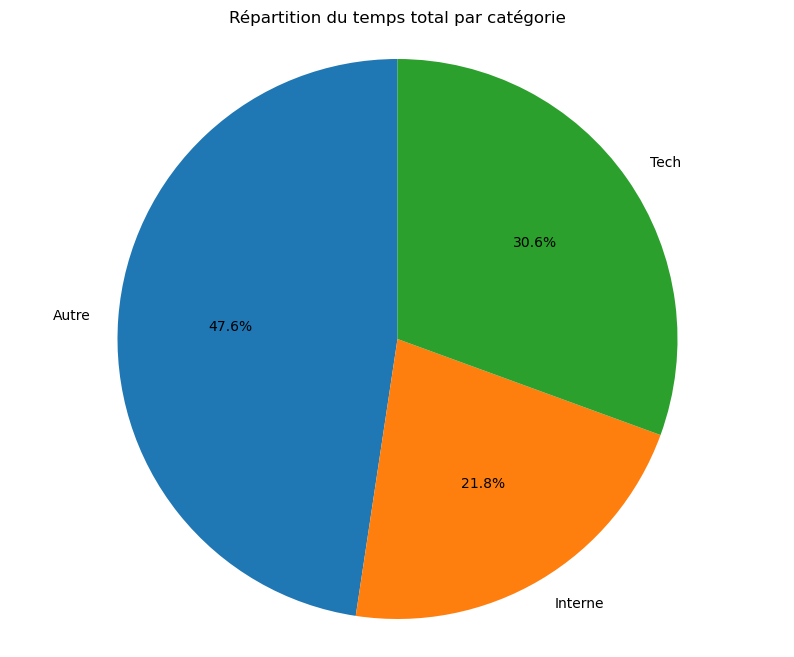

Temps total par catégorie (en heures) :
Autre: 554.35 heures
Interne: 253.92 heures
Tech: 355.92 heures


In [76]:
import matplotlib.pyplot as plt

def extract_user_info(author_json):
    author_dict = json.loads(author_json.replace("'", "\""))
    return author_dict.get('accountId', 'Inconnu')

def extract_category(attributes_json):
    attributes_dict = json.loads(attributes_json.replace("'", "\""))
    values = attributes_dict.get('values', [])
    for value in values:
        if value.get('key') == '_Type_':
            return value.get('value')
    return 'Non défini'

def categorize(category):
    if category in ['Developpement', 'Specification', 'Deploiement','Maquette']:
        return 'Tech'
    elif category in ['Analyse', 'ReunionInterne', 'Code Review']:
        return 'Interne'
    else:
        return 'Autre'

# Extraire l'accountId et la catégorie
tempo_worklogs['accountId'] = tempo_worklogs['author'].apply(extract_user_info)
tempo_worklogs['category'] = tempo_worklogs['attributes'].apply(extract_category)

# Appliquer la nouvelle catégorisation
tempo_worklogs['grouped_category'] = tempo_worklogs['category'].apply(categorize)

# Calculer le temps total pour chaque catégorie groupée
total_time_by_category = tempo_worklogs.groupby('grouped_category')['timeSpentSeconds'].sum()

# Créer le camembert
plt.figure(figsize=(10, 8))
plt.pie(total_time_by_category, labels=total_time_by_category.index, autopct='%1.1f%%', startangle=90)
plt.title('Répartition du temps total par catégorie')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Afficher le graphique
plt.show()

# Afficher les valeurs numériques
print("Temps total par catégorie (en heures) :")
for category, time in total_time_by_category.items():
    print(f"{category}: {time/3600:.2f} heures")

In [ ]:
df = pd.read_csv('IssuesavecCF.csv', delimiter=';')
df.shape 
df.info()
df

In [ ]:
# Function to extract project key from the 'fields' column
def extract_project_key(fields_json):
    try:
        fields = json.loads(fields_json.replace("'", "\""))
        return fields['project']['key']
    except:
        return None

# Extract project key
df['project_key'] = df['fields'].apply(extract_project_key)

# Group by project and sum the estimated hours
project_estimation = df.groupby('project_key')['Macro_estimation_epic_heure'].sum().reset_index()

# Rename columns for clarity
project_estimation = project_estimation.rename(columns={
    'Macro_estimation_epic_heure': 'Estimated_Hours'
})

# Sort by estimated hours descending
project_estimation = project_estimation.sort_values('Estimated_Hours', ascending=False)

# Display the results
print("Estimation par projet (en heures) :")
print(project_estimation)

# Optional: Calculate and display total estimation
total_estimated = project_estimation['Estimated_Hours'].sum()
print(f"\nTotal des heures estimées pour tous les projets : {total_estimated:.2f}")

In [ ]:
# Function to extract project key from the 'fields' column
def extract_project_key(fields_json):
    try:
        fields = json.loads(fields_json.replace("'", "\""))
        return fields['project']['key']
    except:
        return None

# Function to extract issue ID from JSON string in tempo_worklogs
def extract_issue_id(issue_json):
    try:
        issue_dict = json.loads(issue_json.replace("'", "\""))
        return issue_dict['id']
    except:
        return None

# Extract project key from df
df['project_key'] = df['fields'].apply(extract_project_key)

# Extract issue ID from tempo_worklogs
tempo_worklogs['issue_id'] = tempo_worklogs['issue'].apply(extract_issue_id)

# Convert timeSpentSeconds to numeric in tempo_worklogs
tempo_worklogs['timeSpentSeconds'] = pd.to_numeric(tempo_worklogs['timeSpentSeconds'], errors='coerce')

# Merge df with tempo_worklogs
merged_df = pd.merge(df[['id', 'project_key', 'Macro_estimation_epic_heure']], 
                     tempo_worklogs[['issue_id', 'timeSpentSeconds']], 
                     left_on='id', right_on='issue_id', 
                     how='outer')

# Group by project and sum the estimated hours and actual time spent
project_summary = merged_df.groupby('project_key').agg({
    'Macro_estimation_epic_heure': 'sum',
    'timeSpentSeconds': 'sum'
}).reset_index()

# Rename columns for clarity and convert seconds to hours
project_summary = project_summary.rename(columns={
    'Macro_estimation_epic_heure': 'Estimated_Hours',
    'timeSpentSeconds': 'Actual_Seconds'
})
project_summary['Actual_Hours'] = project_summary['Actual_Seconds'] / 3600
#project_summary['Estimated_Hours'] = project_summary['Estimated_Hours'] / 3600

# Sort by estimated hours descending
project_summary = project_summary.sort_values('Estimated_Hours', ascending=False)

# Select and reorder columns
project_summary = project_summary[['project_key', 'Estimated_Hours', 'Actual_Hours']]

# Display the results
print("Estimation et temps réel par projet (en heures) :")
print(project_summary)

# Optional: Calculate and display totals
total_estimated = project_summary['Estimated_Hours'].sum()
total_actual = project_summary['Actual_Hours'].sum()
print(f"\nTotal des heures estimées pour tous les projets : {total_estimated:.2f}")
print(f"Total des heures réelles pour tous les projets : {total_actual:.2f}")
print(f"Différence (Réel - Estimé) : {total_actual - total_estimated:.2f}")